# NHL Age Curves (2018 - 2024)

## DSCI 235

### Justin Eldridge, Cody Farris


# Introduction

We wanted to know how long players in various positions can expect to remain competitive in the NHL. We were specifically interested in how quickly player reach their peak performance, the age at which they peak, and how quickly different aspects of their performance declines with age. To accomplish this we decided to collect 5 seasons worth of skater and goalie data from pro-hockey-reference.com from 2018-2024. We then picked certain performance metrics and plotted them vs. age with a LOESS smoother to examine performance with increasing age.

# Background

There are 6 players on the ice at a given time. These consist of three offensive players (center, left wing, right wing), two defense men, and a goalie. 

In [230]:
#Import the appropriate packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Import the package for LOESS
import statsmodels.api as sm
import os

#Set the working directory
os.chdir('/Users/cody/Documents/GitHub/DSCI235-Project/235_Project')
#os.chdir("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project")

# Data Acquisition and Cleaning:

We collected the player and goalie data for each season as .txt files and read them into python. We then completed some exploratory data analysis and concluded that some of the player positions were labeled inconsitently. For example, some players were labeled as Forwards, while others were labeled as Centers despite this being the same position. We also found that some players filled multiple roles leading them to have multiple positions included. To fix this we created indicator variables for each position so that players who played multiple positions would be included in the graphs for each of those positions. With this cleaning complete we created an overall skater and overal goalie data frames containing the entire time series of data. With the collection and cleaning complete we moved on to picking performance metrics and plotting. 

## Skater Data

In [231]:
# Skater Advanced Data

#skater_a, skater_b, skater_c, skater_d, skater_e, skater_f = (pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\1819_Hockey.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\1920_Hockey.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\2021_Hockey.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\21-22 Season.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\2223_Hockey.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\23-24 Season.txt"))

skater_a, skater_b, skater_c, skater_d, skater_e, skater_f = (pd.read_csv('csv/1819_Hockey.txt'), 
                                                              pd.read_csv('csv/1920_Hockey.txt'), 
                                                              pd.read_csv('csv/2021_Hockey.txt'),
                                                              pd.read_csv('csv/21-22 Season.txt'), 
                                                              pd.read_csv('csv/2223_Hockey.txt'), 
                                                              pd.read_csv('csv/23-24 Season.txt'))

skater_advanced = pd.concat([skater_a, skater_b, skater_c, skater_d, skater_e, skater_f], axis=0)


# skater_advanced.to_csv('Non_Goalie_advanced_data.csv', index=False)

We wanted to dermine how many players there were for each position. We found that the naming conventions were not consistent. Despite Center and Forward being the same position they are enconded differently. We also found that some players fill multiple roles. 

In [232]:
print(skater_advanced['Pos'].value_counts())

Pos
D        2232
C        1995
LW       1034
RW        832
F         213
C/LW       69
C/RW       45
LW/C       21
W          16
C/W        12
D/RW       11
RW/C        7
LW/RW       2
W/C         1
Name: count, dtype: int64


To fix this we decided to create indicator variables for each position of interest: Centers, Wingers, and Defenders

In [233]:
skater_advanced['D'] = np.where(skater_advanced['Pos'].str.contains('D'), 1, 0)
skater_advanced['C'] = np.where(skater_advanced['Pos'].str.contains('C'), 1, 0)
skater_advanced['W'] = np.where(skater_advanced['Pos'].str.contains('W'), 1, 0)

In [234]:
# Skater Basic Data

#skater_a, skater_b, skater_c, skater_d, skater_e, skater_f = (pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\18_19_skater_basic.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\19_20_skater_basic.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\20_21_skater_basic.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\21_22_skater_basic.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\22_23_skater_basic.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\csv\\23_24_skater_basic.txt"))

skater_a, skater_b, skater_c, skater_d, skater_e, skater_f = (pd.read_csv('csv/18_19_skater_basic.txt'), 
                                                              pd.read_csv('csv/19_20_skater_basic.txt'), 
                                                              pd.read_csv('csv/20_21_skater_basic.txt'),
                                                              pd.read_csv('csv/21_22_skater_basic.txt'), 
                                                              pd.read_csv('csv/22_23_skater_basic.txt'), 
                                                              pd.read_csv('csv/23_24_skater_basic.txt'))

skater_basic = pd.concat([skater_a, skater_b, skater_c, skater_d, skater_e, skater_f], axis=0)

skater_basic['D'] = np.where(skater_basic['Pos'].str.contains('D'), 1, 0)
skater_basic['C'] = np.where(skater_basic['Pos'].str.contains('C'), 1, 0)
skater_basic['W'] = np.where(skater_basic['Pos'].str.contains('W'), 1, 0)

# skater_advanced.to_csv('Non_Goalie_advanced_data.csv', index=False)

In [235]:
# Create Goals + Assists  Column

skater_basic['G+A'] = skater_basic['G'] + skater_basic['A']

## Goalie Data

In [236]:
#Load in the data
#df1, df2, df3, df4, df5, df6 = (pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\Goalies 18-19.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\Goalies 19-20.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\Goalies 20-21.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\Goalies 21-22.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\Goalies 22-23.txt"),
#                                pd.read_csv("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project\\csv\\Goalies 23-24.txt"))

df1, df2, df3, df4, df5, df6 = (pd.read_csv("csv/Goalies 18-19.txt"),
                                pd.read_csv("csv/Goalies 19-20.txt"),
                                pd.read_csv("csv/Goalies 20-21.txt"),
                                pd.read_csv("csv/Goalies 21-22.txt"),
                                pd.read_csv("csv/Goalies 22-23.txt"),
                                pd.read_csv("csv/Goalies 23-24.txt"))

#Combine the data sets into a single data frame
goalie_df = pd.concat([df1, df2, df3, df4,df5, df6], axis=0)

#View the results
print(goalie_df.head())

#Drop the last column
goalie_df = goalie_df.drop(columns=['-9999'])


#Save the results to a csv file 
#goalie_df.to_csv("goalie_data.csv")

   Rk             Player   Age Team Pos  GP  GS   W   L  T/O  ...   GA%-  \
0   1       Devan Dubnyk  32.0  MIN   G  67  66  31  28    6  ...   96.0   
1   2        Carey Price  31.0  MTL   G  66  64  35  24    6  ...   92.0   
2   3  Connor Hellebuyck  25.0  WPG   G  63  62  34  23    3  ...   97.0   
3   4   Sergei Bobrovsky  30.0  CBJ   G  62  61  37  24    1  ...   97.0   
4   5       Martin Jones  29.0  SJS   G  62  62  36  19    5  ...  115.0   

   GSAA  GAA/A   GPS  G  A PTS  PIM            Awards      -9999  
0   6.2   2.69  11.1  0  2   2    2               ASG  dubnyde01  
1  14.9   2.64  12.5  0  1   1    2   ASnhl-3Vezina-7  priceca01  
2   5.9   3.09  12.1  0  3   3    4               NaN  helleco01  
3   5.3   2.75  10.4  0  0   0    2  ASnhl-11Vezina-9  bobrose01  
4 -22.9   3.14   7.0  0  1   1    2               NaN  jonesma02  

[5 rows x 30 columns]


# Performance Metrics:

Goalies:
* Save Percentage (SV%): Saves/ Total Shots
* Goals Against Average (GAA): Total Goals Allowed per hour of play time.
* Goals Saved Above Average (GSAA): Number of goals saved above league average given the number of shot attempts.
* Goalie Point Shares (GPS): Estimated number of points contributed to team total due to defensive performance.

Skaters:
* Relative Corsi Percentage (CF%rel): Measures players impact on team puck posession and influence the number of shot attempts
* Plus/Minus (+/-): Goals for - Goals against (while teams are at even strength).
* Goals Plus Assists: Number of goals for + number of asissts.

In [237]:
skater_advanced = skater_advanced[['Age', 'CF% rel', 'C', 'W', 'D']]
skater_advanced.head()

,Age,CF% rel,C,W,D
0,31.0,-2.8,0,1,0
1,25.0,3.3,0,1,0
2,25.0,7.4,0,1,0
3,25.0,-4.1,0,1,0
4,20.0,-1.8,0,1,0


In [238]:
skater_basic = skater_basic[['Age', '+/-', 'G+A', 'C', 'W', 'D']]
skater_basic.head()

,Age,+/-,G+A,C,W,D
0,25.0,24.0,128,0,1,0
1,22.0,3.0,116,1,0,0
2,30.0,2.0,110,0,1,0
3,23.0,2.0,105,1,0,0
4,31.0,18.0,100,1,0,0


In [239]:
goalie_df = goalie_df[['Age', 'SV%', 'GAA', 'GSAA', 'GPS']]
goalie_df.head()

,Age,SV%,GAA,GSAA,GPS
0,32.0,0.913,2.54,6.2,11.1
1,31.0,0.918,2.49,14.9,12.5
2,25.0,0.913,2.90,5.9,12.1
3,30.0,0.913,2.58,5.3,10.4
4,29.0,0.896,2.94,-22.9,7.0


In [240]:
#non_goal_a = pd.read_csv('Non_goalie_advanced_data.csv')
non_goal_a = skater_advanced

#non_goal_b = pd.read_csv('Non_Goalie_basic_data.csv')
non_goal_b = skater_basic

# Plotting and LOESS

We decided to employ LOESS (Locally Estimated Scatterplot Smoothing) to capture any trend in player performance. We employed the lowess() function from the statsmodels package and then also used boostrap sampling to calculated a 95% confidence interval. There is a smoothing parameter in the LOESS model, which we called frac_val, that controls how much of the surrounding data is used to shape the curve. A large smoothing parameter results in more of the surrounding data being considered as the curve is shaped. This means that it is less sensitive to outliers but may not be flexible enough to capture the relationship. On the other hand a small smoothing parameter ($\approx$ 0.1) makes the curve much more flexible, making it better equpped to capture local detail. However this can also make it prone to overfitting as we will see. 

# Goalie Age Curves

## Save Percentage (SV%)

In [241]:
#Define the predictor and response
x = goalie_df['Age'].values
y = goalie_df['SV%'].values

#Sort the values by age for plotting later
index = np.argsort(x)
x_g = x[index]
y_g = y[index]

#Fit the loess model using the statsmodels package
#(start with a small smoothing parameter to capture local detail try others later
loess = sm.nonparametric.lowess

#Set the smoothing parameter so we can fiddle with it
frac_val= 0.15
goalie_fit = loess(y_g, x_g, frac=frac_val, return_sorted=True)

#Extract the fitted values
x_fit = goalie_fit[:,0]
y_fit = goalie_fit[:,1]

#Use bootstrap sampling to calculate the standard error to include in the plot:

#Set the number of boots and create a place to store the reuslts
n_boot = 250
#use nan's instaead of zeros because it was forcing the se to be the same at the ends where there was no support
y_boots= np.full((n_boot,len(x_fit)), np.nan)

#Use a for loop to complete the sampling
for i in range(n_boot):
    
    #Sample with replacement
    sample_idx = np.random.choice(len(x_g), size=len(x_g), replace=True)
    x_sample = x_g[sample_idx]
    y_sample = y_g[sample_idx]

    #Fit the loess 
    loess_boot = loess(y_sample,x_sample,frac=frac_val, return_sorted=True)

    #Extract the results
    x_b = loess_boot[:, 0]
    y_b = loess_boot[:, 1]

    #Use left and right nans to have it only compute se where the loess boot has support
    #Otherwise it will force the tails to have the same se as the rest of the data 
    interp = np.interp(x_fit, x_b, y_b, left=np.nan, right=np.nan)

    #Store the results
    y_boots[i, :] = interp


#Calculate the standard error and ignore the nans
y_std = np.nanstd(y_boots, axis=0)

#Calculate the uper and lower bounds for the 95% CI
y_upper = y_fit + 1.96 * y_std
y_lower = y_fit - 1.96 * y_std

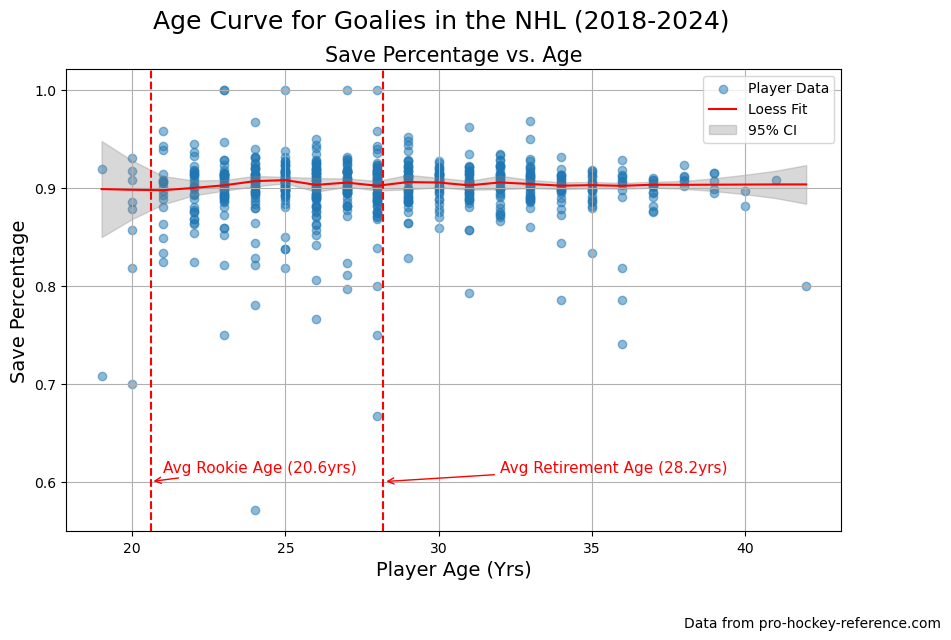

In [242]:
#Plot the results
plt.figure(figsize=(10,6))

#Add the data as a scatter plot
plt.scatter(y=y, x= x, alpha=0.5, label= "Player Data")

#Add the loess curve
plt.plot(x_fit , y_fit, color="red", label= "Loess Fit")

#Add the confidence intervals
plt.fill_between(x_fit, y_lower,y_upper, color='gray', alpha=0.3, label="95% CI")

#Add a vertical line for the mean age of a rookie in the nhl
#source: https://pmc.ncbi.nlm.nih.gov/articles/PMC4035396/
plt.axvline(x=20.6, color='red', linestyle='--')

#Add a verticle cline for the mean retirement age in the nhl
plt.axvline(x=28.2, color='red', linestyle='--')

#Add appropriate labels and title
plt.suptitle("Age Curve for Goalies in the NHL (2018-2024)", fontsize=18)
plt.ylabel("Save Percentage", fontsize=14)
plt.xlabel("Player Age (Yrs)", fontsize=14)
plt.title("Save Percentage vs. Age", fontsize=15)
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')

#Add a text annotation that indicates that the red vertical line is the mean age for rookies in the nhl
plt.annotate("Avg Rookie Age (20.6yrs)",
             xy=(20.6, 0.6),
             xytext=(21,0.6+0.01),
             arrowprops=dict(arrowstyle= "->", color='red'),
             color='red',
             fontsize=11)

#Add a text annotation to indicate the average retirement age for players in the nhl
#source: https://www.rbcwealthmanagement.com/en-us/insights/professional-athletes-need-a-retirement-game-plan#:~:text=That%20means%20the%20average%20professional,and%2027.6%20for%20NFL%20players.
plt.annotate("Avg Retirement Age (28.2yrs)",
             xy=(28.2, 0.6),
             xytext=(32,0.6+0.01),
             arrowprops=dict(arrowstyle= "->", color='red'),
             color='red',
             fontsize=11)

#Add the grid lines for easy viewing
plt.grid(True)

#Add the legend
plt.legend()

#Display the plot
plt.show()

## Goals Against Average (GAA)

In [243]:
#Define the predictor and response
x = goalie_df['Age'].values
y = goalie_df['GAA'].values

#Sort the values by age for plotting later
index = np.argsort(x)
x_g = x[index]
y_g = y[index]

#Fit the loess model using the statsmodels package
#(start with a small smoothing parameter to capture local detail try others later
loess = sm.nonparametric.lowess

#Set the smoothing parameter so we can fiddle with it
frac_val= 0.15
goalie_fit = loess(y_g, x_g, frac=frac_val, return_sorted=True)

#Extract the fitted values
x_fit = goalie_fit[:,0]
y_fit = goalie_fit[:,1]

#Use bootstrap sampling to calculate the standard error to include in the plot:

#Set the number of boots and create a place to store the reuslts
n_boot = 250
#use nan's instaead of zeros because it was forcing the se to be the same at the ends where there was no support
y_boots= np.full((n_boot,len(x_fit)), np.nan)

#Use a for loop to complete the sampling
for i in range(n_boot):
    
    #Sample with replacement
    sample_idx = np.random.choice(len(x_g), size=len(x_g), replace=True)
    x_sample = x_g[sample_idx]
    y_sample = y_g[sample_idx]

    #Fit the loess 
    loess_boot = loess(y_sample,x_sample,frac=frac_val, return_sorted=True)

    #Extract the results
    x_b = loess_boot[:, 0]
    y_b = loess_boot[:, 1]

    #Use left and right nans to have it only compute se where the loess boot has support
    #Otherwise it will force the tails to have the same se as the rest of the data 
    interp = np.interp(x_fit, x_b, y_b, left=np.nan, right=np.nan)

    #Store the results
    y_boots[i, :] = interp


#Calculate the standard error and ignore the nans
y_std = np.nanstd(y_boots, axis=0)

#Calculate the uper and lower bounds for the 95% CI
y_upper = y_fit + 1.96 * y_std
y_lower = y_fit - 1.96 * y_std

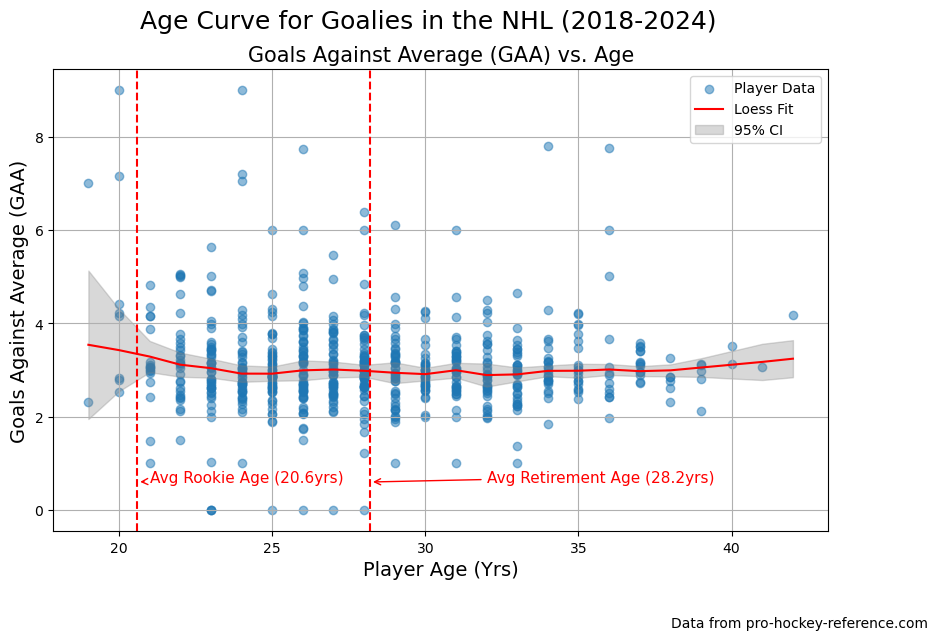

In [244]:
#Plot the results
plt.figure(figsize=(10,6))

#Add the data as a scatter plot
plt.scatter(y=y, x= x, alpha=0.5, label= "Player Data")

#Add the loess curve
plt.plot(x_fit , y_fit, color="red", label= "Loess Fit")

#Add the confidence intervals
plt.fill_between(x_fit, y_lower,y_upper, color='gray', alpha=0.3, label="95% CI")

#Add a vertical line for the mean age of a rookie in the nhl
#source: https://pmc.ncbi.nlm.nih.gov/articles/PMC4035396/
plt.axvline(x=20.6, color='red', linestyle='--')
plt.axvline(x=28.2, color='red', linestyle='--')

#Add appropriate labels and title
plt.suptitle("Age Curve for Goalies in the NHL (2018-2024)", fontsize=18)
plt.ylabel("Goals Against Average (GAA)", fontsize=14)
plt.xlabel("Player Age (Yrs)", fontsize=14)
plt.title("Goals Against Average (GAA) vs. Age", fontsize=15)
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')

#Add a text annotation that indicates that the red vertical line is the mean age for rookies in the nhl
plt.annotate("Avg Rookie Age (20.6yrs)",
             xy=(20.6, 0.6),
             xytext=(21,0.6+0.01),
             arrowprops=dict(arrowstyle= "->", color='red'),
             color='red',
             fontsize=11)

#Add a vertical line to the plot showing the average retirement age for players
plt.annotate("Avg Retirement Age (28.2yrs)",
             xy=(28.2, 0.6),
             xytext=(32,0.6+0.01),
             arrowprops=dict(arrowstyle= "->", color='red'),
             color='red',
             fontsize=11)

#Add the grid lines for easy viewing
plt.grid(True)

#Add the legend
plt.legend()

#Display the plot
plt.show()

## Goals Saved Above Average (GSAA)

In [245]:
#Define the predictor and response
x = goalie_df['Age'].values
y = goalie_df['GSAA'].values

#Sort the values by age for plotting later
index = np.argsort(x)
x_g = x[index]
y_g = y[index]

#Fit the loess model using the statsmodels package
#(start with a small smoothing parameter to capture local detail try others later
loess = sm.nonparametric.lowess

#Set the smoothing parameter so we can fiddle with it
frac_val= 0.15
goalie_fit = loess(y_g, x_g, frac=frac_val, return_sorted=True)

#Extract the fitted values
x_fit = goalie_fit[:,0]
y_fit = goalie_fit[:,1]

#Use bootstrap sampling to calculate the standard error to include in the plot:

#Set the number of boots and create a place to store the reuslts
n_boot = 250
#use nan's instaead of zeros because it was forcing the se to be the same at the ends where there was no support
y_boots= np.full((n_boot,len(x_fit)), np.nan)

#Use a for loop to complete the sampling
for i in range(n_boot):
    
    #Sample with replacement
    sample_idx = np.random.choice(len(x_g), size=len(x_g), replace=True)
    x_sample = x_g[sample_idx]
    y_sample = y_g[sample_idx]

    #Fit the loess 
    loess_boot = loess(y_sample,x_sample,frac=frac_val, return_sorted=True)

    #Extract the results
    x_b = loess_boot[:, 0]
    y_b = loess_boot[:, 1]

    #Use left and right nans to have it only compute se where the loess boot has support
    #Otherwise it will force the tails to have the same se as the rest of the data 
    interp = np.interp(x_fit, x_b, y_b, left=np.nan, right=np.nan)

    #Store the results
    y_boots[i, :] = interp


#Calculate the standard error and ignore the nans
y_std = np.nanstd(y_boots, axis=0)

#Calculate the uper and lower bounds for the 95% CI
y_upper = y_fit + 1.96 * y_std
y_lower = y_fit - 1.96 * y_std

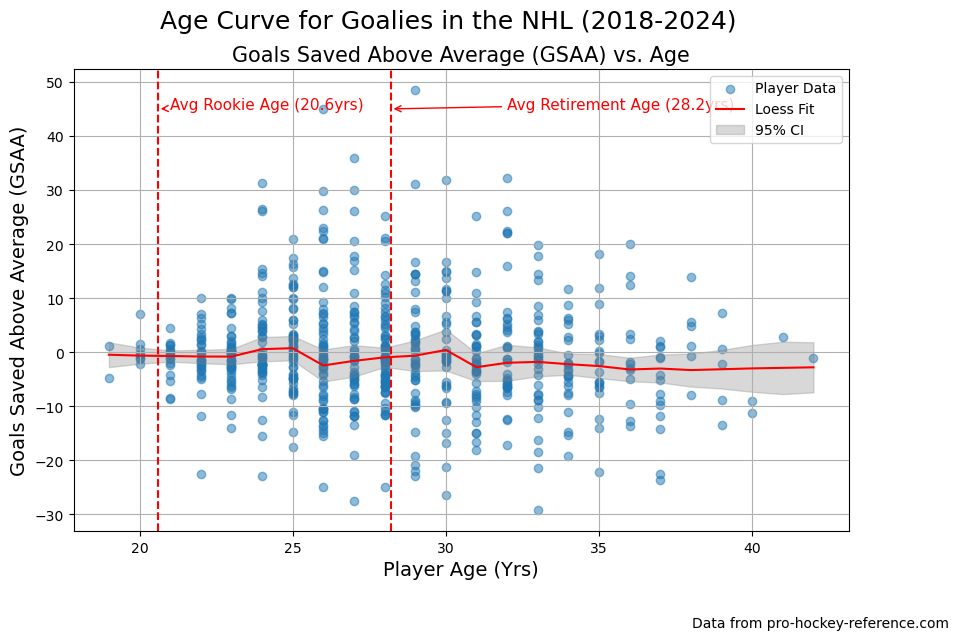

In [246]:
#Plot the results
plt.figure(figsize=(10,6))

#Add the data as a scatter plot
plt.scatter(y=y, x= x, alpha=0.5, label= "Player Data")

#Add the loess curve
plt.plot(x_fit , y_fit, color="red", label= "Loess Fit")

#Add the confidence intervals
plt.fill_between(x_fit, y_lower,y_upper, color='gray', alpha=0.3, label="95% CI")

#Add a vertical line for the mean age of a rookie in the nhl
#source: https://pmc.ncbi.nlm.nih.gov/articles/PMC4035396/
plt.axvline(x=20.6, color='red', linestyle='--')
plt.axvline(x=28.2, color='red', linestyle='--')

#Add appropriate labels and title
plt.suptitle("Age Curve for Goalies in the NHL (2018-2024)", fontsize=18)
plt.ylabel("Goals Saved Above Average (GSAA)", fontsize=14)
plt.xlabel("Player Age (Yrs)", fontsize=14)
plt.title("Goals Saved Above Average (GSAA) vs. Age", fontsize=15)
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')

#Add a text annotation that indicates that the red vertical line is the mean age for rookies in the nhl
plt.annotate("Avg Rookie Age (20.6yrs)",
             xy=(20.6, 45),
             xytext=(21,45+0.01),
             arrowprops=dict(arrowstyle= "->", color='red'),
             color='red',
             fontsize=11)

#Add a vertical line to the plot showing the average retirement age for players
plt.annotate("Avg Retirement Age (28.2yrs)",
             xy=(28.2, 45),
             xytext=(32,45+0.01),
             arrowprops=dict(arrowstyle= "->", color='red'),
             color='red',
             fontsize=11)

#Add the grid lines for easy viewing
plt.grid(True)

#Add the legend
plt.legend()

#Display the plot
plt.show()

## Goalie Point Shares (GPS)

In [247]:
#Define the predictor and response
x = goalie_df['Age'].values
y = goalie_df['GPS'].values

#Sort the values by age for plotting later
index = np.argsort(x)
x_g = x[index]
y_g = y[index]

#Fit the loess model using the statsmodels package
#(start with a small smoothing parameter to capture local detail try others later
loess = sm.nonparametric.lowess

#Set the smoothing parameter so we can fiddle with it
frac_val= 0.4
goalie_fit = loess(y_g, x_g, frac=frac_val, return_sorted=True)

#Extract the fitted values
x_fit = goalie_fit[:,0]
y_fit = goalie_fit[:,1]

#Use bootstrap sampling to calculate the standard error to include in the plot:

#Set the number of boots and create a place to store the reuslts
n_boot = 250
#use nan's instaead of zeros because it was forcing the se to be the same at the ends where there was no support
y_boots= np.full((n_boot,len(x_fit)), np.nan)

#Use a for loop to complete the sampling
for i in range(n_boot):
    
    #Sample with replacement
    sample_idx = np.random.choice(len(x_g), size=len(x_g), replace=True)
    x_sample = x_g[sample_idx]
    y_sample = y_g[sample_idx]

    #Fit the loess 
    loess_boot = loess(y_sample,x_sample,frac=frac_val, return_sorted=True)

    #Extract the results
    x_b = loess_boot[:, 0]
    y_b = loess_boot[:, 1]

    #Use left and right nans to have it only compute se where the loess boot has support
    #Otherwise it will force the tails to have the same se as the rest of the data 
    interp = np.interp(x_fit, x_b, y_b, left=np.nan, right=np.nan)

    #Store the results
    y_boots[i, :] = interp


#Calculate the standard error and ignore the nans
y_std = np.nanstd(y_boots, axis=0)

#Calculate the uper and lower bounds for the 95% CI
y_upper = y_fit + 1.96 * y_std
y_lower = y_fit - 1.96 * y_std

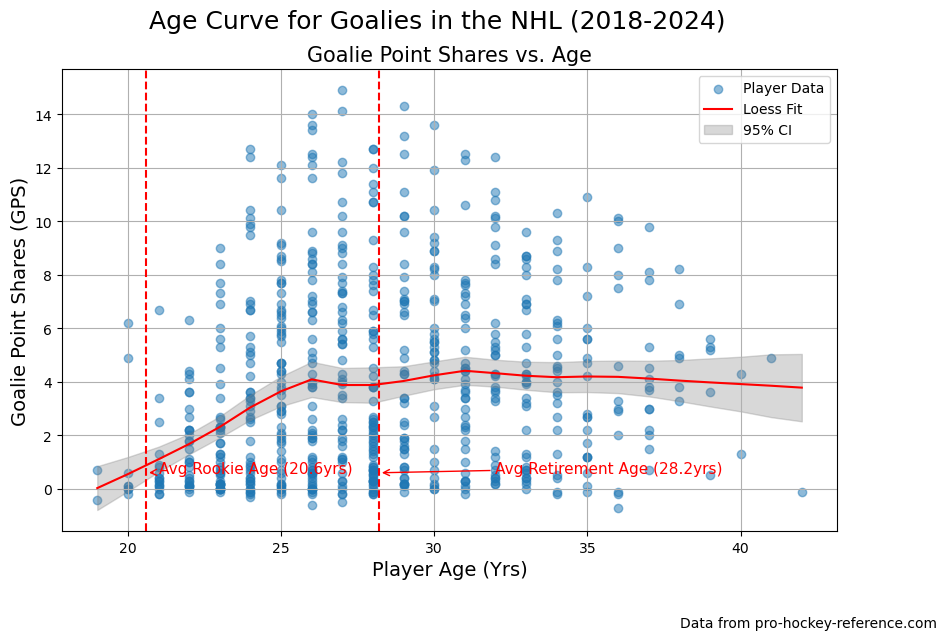

In [248]:
#Plot the results
plt.figure(figsize=(10,6))

#Add the data as a scatter plot
plt.scatter(y=y, x= x, alpha=0.5, label= "Player Data")

#Add the loess curve
plt.plot(x_fit , y_fit, color="red", label= "Loess Fit")

#Add the confidence intervals
plt.fill_between(x_fit, y_lower,y_upper, color='gray', alpha=0.3, label="95% CI")

#Add a vertical line for the mean age of a rookie in the nhl
#source: https://pmc.ncbi.nlm.nih.gov/articles/PMC4035396/
plt.axvline(x=20.6, color='red', linestyle='--')
plt.axvline(x=28.2, color='red', linestyle='--')

#Add appropriate labels and title
plt.suptitle("Age Curve for Goalies in the NHL (2018-2024)", fontsize=18)
plt.ylabel("Goalie Point Shares (GPS)", fontsize=14)
plt.xlabel("Player Age (Yrs)", fontsize=14)
plt.title("Goalie Point Shares vs. Age", fontsize=15)
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')

#Add a text annotation that indicates that the red vertical line is the mean age for rookies in the nhl
plt.annotate("Avg Rookie Age (20.6yrs)",
             xy=(20.6, 0.6),
             xytext=(21,0.6+0.01),
             arrowprops=dict(arrowstyle= "->", color='red'),
             color='red',
             fontsize=11)

#Add a vertical line to the plot showing the average retirement age for players
plt.annotate("Avg Retirement Age (28.2yrs)",
             xy=(28.2, 0.6),
             xytext=(32,0.6+0.01),
             arrowprops=dict(arrowstyle= "->", color='red'),
             color='red',
             fontsize=11)

#Add the grid lines for easy viewing
plt.grid(True)

#Add the legend
plt.legend()

#Display the plot
plt.show()

# Skater (Winger, Center, Defender) Age Curves

## Relative Corsi Percentage

In [249]:
defender_a = non_goal_a[(non_goal_a['D']==1)]
winger_a = non_goal_a[(non_goal_a['W']==1)]
center_a = non_goal_a[(non_goal_a['C']==1)]

In [250]:
## Defender - Relative Corsi Percentage

frac = 0.15

x_dd = defender_a['Age'].values
y_dd = defender_a['CF% rel'].values
index = np.argsort(x_dd)
x_dd = x_dd[index]
y_dd = y_dd[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dd, x_dd, frac=frac, return_sorted=True)
xd_fitd = loess_result[:, 0]
yd_fitd = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitd)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dd), size=len(x_dd), replace=True)
    y_sample = y_dd[sample_idx]
    x_sample = x_dd[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bd = loess_boot[:,1]
    x_bd = loess_boot[:,0]

    interp = np.interp(xd_fitd, x_bd, y_bd, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_d = np.nanstd(y_boots, axis=0)
upper_band_d = yd_fitd + 1.96 * std_d
lower_band_d = yd_fitd - 1.96 * std_d

## Winger - Relative Corsi Percentage

x_dw = winger_a['Age'].values
y_dw = winger_a['CF% rel'].values
index = np.argsort(x_dw)
x_dw = x_dw[index]
y_dw = y_dw[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dw, x_dw, frac=frac, return_sorted=True)
xd_fitw = loess_result[:, 0]
yd_fitw = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitw)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dw), size=len(x_dw), replace=True)
    y_sample = y_dw[sample_idx]
    x_sample = x_dw[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bw = loess_boot[:,1]
    x_bw = loess_boot[:,0]

    interp = np.interp(xd_fitw, x_bw, y_bw, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_w = np.nanstd(y_boots, axis=0)
upper_band_w = yd_fitw + 1.96 * std_w
lower_band_w = yd_fitw - 1.96 * std_w

## Center - Relative Corsi Percentage

x_dc = center_a['Age'].values
y_dc = center_a['CF% rel'].values
index = np.argsort(x_dc)
x_dc = x_dc[index]
y_dc = y_dc[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dc, x_dc, frac=frac, return_sorted=True)
xd_fitc = loess_result[:, 0]
yd_fitc = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitc)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dc), size=len(x_dc), replace=True)
    y_sample = y_dc[sample_idx]
    x_sample = x_dc[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bc = loess_boot[:,1]
    x_bc = loess_boot[:,0]

    interp = np.interp(xd_fitc, x_bc, y_bc, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_c = np.nanstd(y_boots, axis=0)
upper_band_c = yd_fitc + 1.96 * std_c
lower_band_c = yd_fitc - 1.96 * std_c

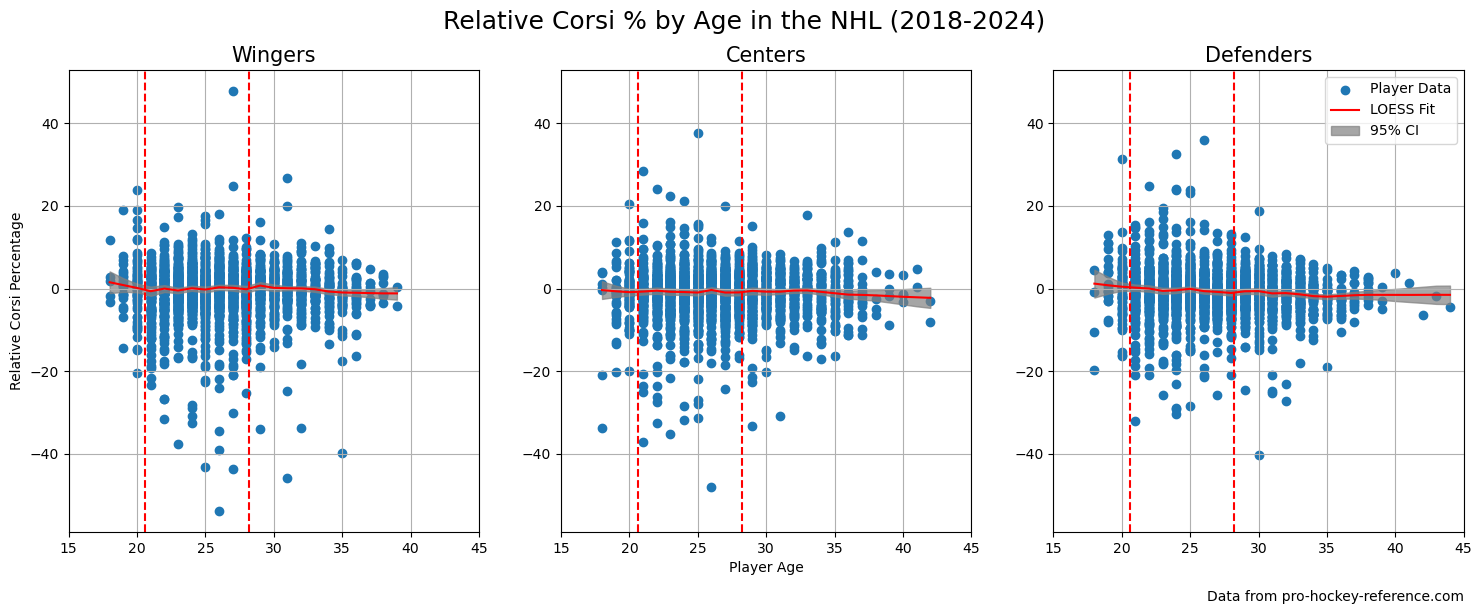

In [251]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].scatter(x_dw,y_dw, label='Player Data')
axes[0].plot(xd_fitw,yd_fitw, color='red', label='LOESS Fit')
axes[0].fill_between(xd_fitw, lower_band_w, upper_band_w, color='gray', alpha=0.7, label='95% CI')
axes[0].set_title('Wingers', fontsize=15)
axes[0].set_ylabel('Relative Corsi Percentage')
axes[0].grid(True)
axes[0].set_xlim(15,45)
axes[0].axvline(x=20.6, color='red', linestyle='--')
axes[0].axvline(x=28.2, color='red', linestyle='--')

axes[1].scatter(x_dc,y_dc, label='Player Data')
axes[1].plot(xd_fitc,yd_fitc, color='red', label='LOESS Fit')
axes[1].fill_between(xd_fitc, lower_band_c, upper_band_c, color='gray', alpha=0.7, label='95% CI')
axes[1].set_title('Centers', fontsize=15)
axes[1].set_xlabel('Player Age')
axes[1].grid(True)
axes[1].set_xlim(15,45)
axes[1].yaxis.set_tick_params(labelleft=True)
axes[1].axvline(x=20.6, color='red', linestyle='--')
axes[1].axvline(x=28.2, color='red', linestyle='--')

axes[2].scatter(x_dd,y_dd, label='Player Data')
axes[2].plot(xd_fitd,yd_fitd, color='red', label='LOESS Fit')
axes[2].fill_between(xd_fitd, lower_band_d, upper_band_d, color='gray', alpha=0.7, label='95% CI')
axes[2].set_title('Defenders', fontsize=15)
axes[2].grid(True)
axes[2].set_xlim(15,45)
axes[2].yaxis.set_tick_params(labelleft=True)
axes[2].axvline(x=20.6, color='red', linestyle='--')
axes[2].axvline(x=28.2, color='red', linestyle='--')

fig.suptitle("Relative Corsi % by Age in the NHL (2018-2024)", fontsize=18)
fig.text(0.9, -0.005, "Data from pro-hockey-reference.com", ha='right')
plt.legend();

## Plus / Minus

In [252]:
defender_b = non_goal_b[(non_goal_b['D']==1)]
winger_b = non_goal_b[(non_goal_b['W']==1)]
center_b = non_goal_b[(non_goal_b['C']==1)]

In [253]:
## Defender - Plus/Minus

frac = 0.15

x_dd = defender_b['Age'].values
y_dd = defender_b['+/-'].values
index = np.argsort(x_dd)
x_dd = x_dd[index]
y_dd = y_dd[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dd, x_dd, frac=frac, return_sorted=True)
xd_fitd = loess_result[:, 0]
yd_fitd = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitd)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dd), size=len(x_dd), replace=True)
    y_sample = y_dd[sample_idx]
    x_sample = x_dd[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bd = loess_boot[:,1]
    x_bd = loess_boot[:,0]

    interp = np.interp(xd_fitd, x_bd, y_bd, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_d = np.nanstd(y_boots, axis=0)
upper_band_d = yd_fitd + 1.96 * std_d
lower_band_d = yd_fitd - 1.96 * std_d

## Winger - Plus/Minus

x_dw = winger_b['Age'].values
y_dw = winger_b['+/-'].values
index = np.argsort(x_dw)
x_dw = x_dw[index]
y_dw = y_dw[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dw, x_dw, frac=frac, return_sorted=True)
xd_fitw = loess_result[:, 0]
yd_fitw = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitw)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dw), size=len(x_dw), replace=True)
    y_sample = y_dw[sample_idx]
    x_sample = x_dw[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bw = loess_boot[:,1]
    x_bw = loess_boot[:,0]

    interp = np.interp(xd_fitw, x_bw, y_bw, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_w = np.nanstd(y_boots, axis=0)
upper_band_w = yd_fitw + 1.96 * std_w
lower_band_w = yd_fitw - 1.96 * std_w

## Center - Plus/Minus

x_dc = center_b['Age'].values
y_dc = center_b['+/-'].values
index = np.argsort(x_dc)
x_dc = x_dc[index]
y_dc = y_dc[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dc, x_dc, frac=frac, return_sorted=True)
xd_fitc = loess_result[:, 0]
yd_fitc = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitc)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dc), size=len(x_dc), replace=True)
    y_sample = y_dc[sample_idx]
    x_sample = x_dc[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bc = loess_boot[:,1]
    x_bc = loess_boot[:,0]

    interp = np.interp(xd_fitc, x_bc, y_bc, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_c = np.nanstd(y_boots, axis=0)
upper_band_c = yd_fitc + 1.96 * std_c
lower_band_c = yd_fitc - 1.96 * std_c

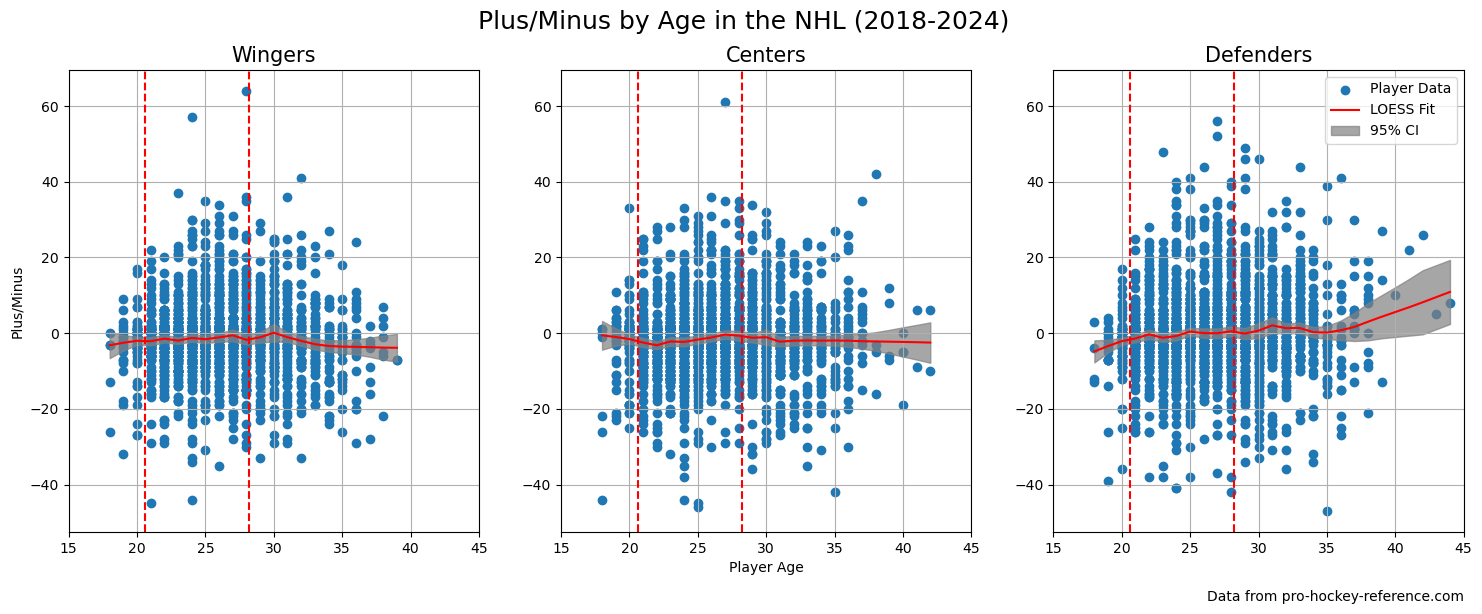

In [254]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].scatter(x_dw,y_dw, label='Player Data')
axes[0].plot(xd_fitw,yd_fitw, color='red', label='LOESS Fit')
axes[0].fill_between(xd_fitw, lower_band_w, upper_band_w, color='gray', alpha=0.7, label='95% CI')
axes[0].set_title('Wingers', fontsize=15)
axes[0].set_ylabel('Plus/Minus')
axes[0].grid(True)
axes[0].set_xlim(15,45)
axes[0].axvline(x=20.6, color='red', linestyle='--')
axes[0].axvline(x=28.2, color='red', linestyle='--')

axes[1].scatter(x_dc,y_dc, label='Player Data')
axes[1].plot(xd_fitc,yd_fitc, color='red', label='LOESS Fit')
axes[1].fill_between(xd_fitc, lower_band_c, upper_band_c, color='gray', alpha=0.7, label='95% CI')
axes[1].set_title('Centers', fontsize=15)
axes[1].set_xlabel('Player Age')
axes[1].grid(True)
axes[1].set_xlim(15,45)
axes[1].yaxis.set_tick_params(labelleft=True)
axes[1].axvline(x=20.6, color='red', linestyle='--')
axes[1].axvline(x=28.2, color='red', linestyle='--')

axes[2].scatter(x_dd,y_dd, label='Player Data')
axes[2].plot(xd_fitd,yd_fitd, color='red', label='LOESS Fit')
axes[2].fill_between(xd_fitd, lower_band_d, upper_band_d, color='gray', alpha=0.7, label='95% CI')
axes[2].set_title('Defenders', fontsize=15)
axes[2].grid(True)
axes[2].set_xlim(15,45)
axes[2].yaxis.set_tick_params(labelleft=True)
axes[2].axvline(x=20.6, color='red', linestyle='--')
axes[2].axvline(x=28.2, color='red', linestyle='--')

fig.suptitle("Plus/Minus by Age in the NHL (2018-2024)", fontsize=18)
fig.text(0.9, -0.005, "Data from pro-hockey-reference.com", ha='right')
plt.legend();

## Goals and Assists

In [255]:
## Defender - Goals + Assists

frac = 0.15

x_dd = defender_b['Age'].values
y_dd = defender_b['G+A'].values
index = np.argsort(x_dd)
x_dd = x_dd[index]
y_dd = y_dd[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dd, x_dd, frac=frac, return_sorted=True)
xd_fitd = loess_result[:, 0]
yd_fitd = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitd)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dd), size=len(x_dd), replace=True)
    y_sample = y_dd[sample_idx]
    x_sample = x_dd[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bd = loess_boot[:,1]
    x_bd = loess_boot[:,0]

    interp = np.interp(xd_fitd, x_bd, y_bd, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_d = np.nanstd(y_boots, axis=0)
upper_band_d = yd_fitd + 1.96 * std_d
lower_band_d = yd_fitd - 1.96 * std_d

## Winger - Goals + Assists

x_dw = winger_b['Age'].values
y_dw = winger_b['G+A'].values
index = np.argsort(x_dw)
x_dw = x_dw[index]
y_dw = y_dw[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dw, x_dw, frac=frac, return_sorted=True)
xd_fitw = loess_result[:, 0]
yd_fitw = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitw)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dw), size=len(x_dw), replace=True)
    y_sample = y_dw[sample_idx]
    x_sample = x_dw[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bw = loess_boot[:,1]
    x_bw = loess_boot[:,0]

    interp = np.interp(xd_fitw, x_bw, y_bw, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_w = np.nanstd(y_boots, axis=0)
upper_band_w = yd_fitw + 1.96 * std_w
lower_band_w = yd_fitw - 1.96 * std_w

## Center - Goals + Assists

x_dc = center_b['Age'].values
y_dc = center_b['G+A'].values
index = np.argsort(x_dc)
x_dc = x_dc[index]
y_dc = y_dc[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dc, x_dc, frac=frac, return_sorted=True)
xd_fitc = loess_result[:, 0]
yd_fitc = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitc)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dc), size=len(x_dc), replace=True)
    y_sample = y_dc[sample_idx]
    x_sample = x_dc[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bc = loess_boot[:,1]
    x_bc = loess_boot[:,0]

    interp = np.interp(xd_fitc, x_bc, y_bc, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_c = np.nanstd(y_boots, axis=0)
upper_band_c = yd_fitc + 1.96 * std_c
lower_band_c = yd_fitc - 1.96 * std_c

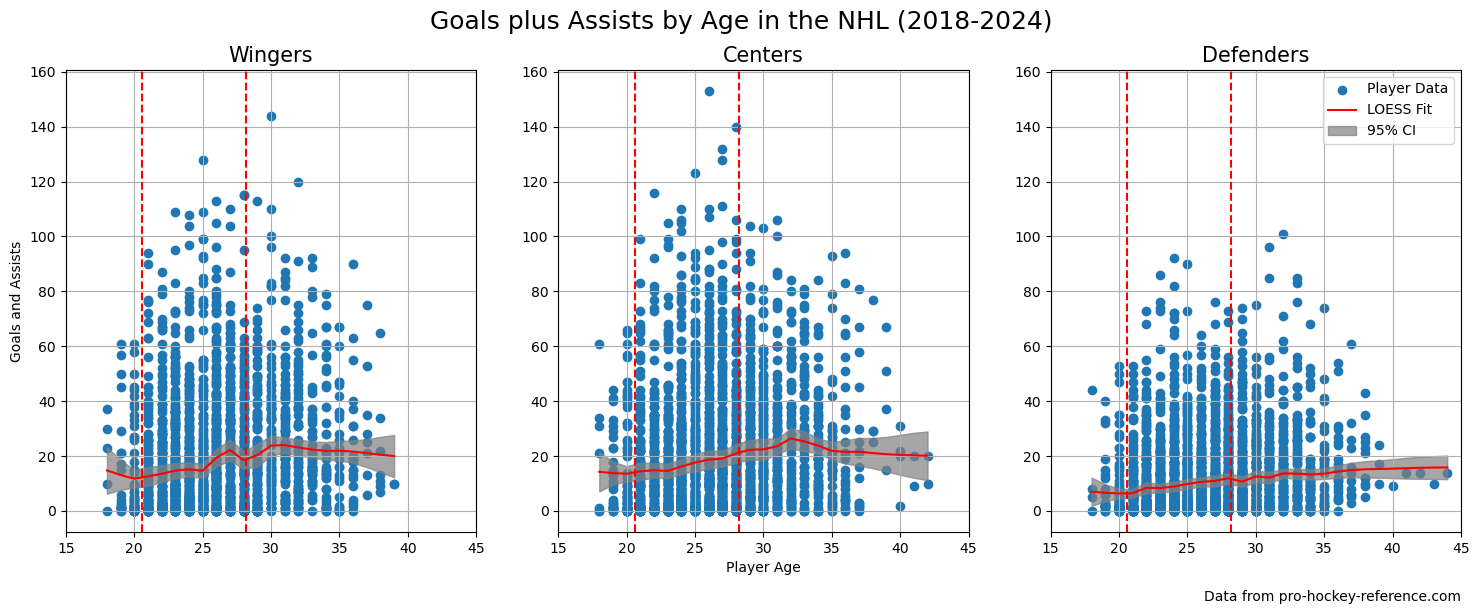

In [257]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].scatter(x_dw,y_dw, label='Player Data')
axes[0].plot(xd_fitw,yd_fitw, color='red', label='LOESS Fit')
axes[0].fill_between(xd_fitw, lower_band_w, upper_band_w, color='gray', alpha=0.7, label='95% CI')
axes[0].set_title('Wingers', fontsize=15)
axes[0].set_ylabel('Goals and Assists')
axes[0].grid(True)
axes[0].set_xlim(15,45)
axes[0].axvline(x=20.6, color='red', linestyle='--')
axes[0].axvline(x=28.2, color='red', linestyle='--')

axes[1].scatter(x_dc,y_dc, label='Player Data')
axes[1].plot(xd_fitc,yd_fitc, color='red', label='LOESS Fit')
axes[1].fill_between(xd_fitc, lower_band_c, upper_band_c, color='gray', alpha=0.7, label='95% CI')
axes[1].set_title('Centers', fontsize=15)
axes[1].set_xlabel('Player Age')
axes[1].grid(True)
axes[1].set_xlim(15,45)
axes[1].yaxis.set_tick_params(labelleft=True)
axes[1].axvline(x=20.6, color='red', linestyle='--')
axes[1].axvline(x=28.2, color='red', linestyle='--')

axes[2].scatter(x_dd,y_dd, label='Player Data')
axes[2].plot(xd_fitd,yd_fitd, color='red', label='LOESS Fit')
axes[2].fill_between(xd_fitd, lower_band_d, upper_band_d, color='gray', alpha=0.7, label='95% CI')
axes[2].set_title('Defenders', fontsize=15)
axes[2].grid(True)
axes[2].set_xlim(15,45)
axes[2].yaxis.set_tick_params(labelleft=True)
axes[2].axvline(x=20.6, color='red', linestyle='--')
axes[2].axvline(x=28.2, color='red', linestyle='--')

fig.suptitle("Goals plus Assists by Age in the NHL (2018-2024)", fontsize=18)
fig.text(0.9, -0.005, "Data from pro-hockey-reference.com", ha='right')
plt.legend();